## Cellular Marker Profiling Example

This notebook demonstrates how to do the following with Cytokit:

- Organize raw microscope images for processing (as tif files)
- Define a configuration
- Run image pre-processing and segmentation
- Analyze results via Python
- Analyze results via Cytokit Explorer

The dataset used in this example is a subset of an experimental replicate that captured a 5x5 grid of images of human t cells labeled with CD4 and CD8 antibodies.  DAPI and Phalloidin-iFluor 594 dyes were used to identify cell nuclei and boundaries, respectively.  

This subset is used to make the example faster and easier to recreate, but for a full scale analysis of this experiment see this [notebook](https://github.com/hammerlab/cytokit/blob/ba73d8b7d9dd4b3286df8bd8afe22826bd7e44f9/pub/analysis/cellular-marker/analysis.md).

In [1]:
%matplotlib inline
import os
import tqdm
import tempfile
import numpy as np
import urllib.request
import os.path as osp
import matplotlib.pyplot as plt
from cytokit import io as ck_io
from cytokit import config as ck_config
from cytokit.function import data as ck_data
from cytokit.image import proc as ck_img_proc

---

## Download Raw Data

The data used in this example is a subset of a single replicate of an experiment available at https://storage.googleapis.com/cytokit/datasets/cellular-marker.  For the sake of demonstration, only one tile of 25 (in original 5x5 grid) as well as 7 z planes of 25 will be downloaded for processing.

Each of the raw images downloaded below is expected to contain indexes for the following dimensions of an experiment somewhere in its path:

- region
- tile
- cycle
- z plane
- channel

In this case, there will be only one region, tile, and cycle.  Each image will be saved in a temporary directory created to contain everything related to this example:

In [2]:
exp_name = '20181116-d40-r1-20x-5by5'
exp_dir = osp.join(tempfile.gettempdir(), 'cytokit-example', 'cellular-marker', exp_name)

# Raw image directory (will be read-only after initial download)
raw_dir = osp.join(exp_dir, 'raw')

# Output directory (will contain all processed images, csvs, and fcs files)
out_dir = osp.join(exp_dir, 'output')

In [3]:
# Construct the URLs for the raw images corresponding to the subset of interest
url_format = 'https://storage.googleapis.com/cytokit/datasets/cellular-marker/{exp}/1_00001_Z{z:03d}_CH{ch}.tif'
urls = [
    url_format.format(exp=exp_name, z=z, ch=ch) 
    for z in range(14, 21) for ch in range(1, 5)
]

# Download each URL as a file in the temporary directory
for url in tqdm.tqdm(urls):
    path = osp.join(raw_dir, osp.basename(url))
    if not osp.exists(osp.dirname(path)):
        os.makedirs(osp.dirname(path))
    if not osp.exists(path):
        urllib.request.urlretrieve(url, path)
        
# Show naming conventions via example paths
print('Downloaded image files saved to %s' % raw_dir)
print('Example files:')
!find $raw_dir/*.tif | head

100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Downloaded image files saved to /tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw
Example files:
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z014_CH1.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z014_CH2.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z014_CH3.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z014_CH4.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z015_CH1.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z015_CH2.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z015_CH3.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z015_CH4.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z016_CH1.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/raw/1_00001_Z016_CH2.tif


---

## Configuration

All Cytokit experiment configurations are represented as yaml documents and a typical use case involving these documents would be to define one "template" or "base" configuration for a project that contains all information likely to be shared across replicates or varying parameterizations in processing.  

While it would be possible to manually create separate configuration files for each of these, the primary purpose of Cytokit is to make batch processing like this more manageable across many replicates and processing configurations.  To this end, the ```cytokit config editor``` command can be used to make small changes to a template configuration and an example of this is shown below.

See [experiment_pha.yaml](https://github.com/hammerlab/cytokit/blob/ba73d8b7d9dd4b3286df8bd8afe22826bd7e44f9/pub/config/cellular-marker/experiment_pha.yaml) for more details on the base configuration being modified here.  Note below that nearly all the changes made to the configuration are related to defining a subset of the original experiment and in particular, ```index_symlinks``` provides a way to remap any of the indexes mentioned as required in image paths in the section above to a new range.  This is used below to select 7 of 25 z-planes (from index 14 to index 20) but could also be used to define tile or channel subsets as well:

In [4]:
%%bash -s "$out_dir"

# The config editor requires a base configuration as well as the target output location in which the resulting config should be stored.
# The convention used (in our lab at least) is to name "variants" of an experiment with a tag like "v00" or "v01" where each represents
# a different processing configuration and both the config file as well as all associated data will be stored in a directory named by that tag.
cytokit config editor --base-config-path=/lab/repos/cytokit/pub/config/cellular-marker/experiment_pha.yaml --output-dir=$1 \
set name 'Cellular Marker Example' \
set acquisition.region_height 1 \
set acquisition.region_width 1 \
set acquisition.num_z_planes 7 \
set environment.index_symlinks '{z:{1:14,2:15,3:16,4:17,5:18,6:19,7:20}}' \
save_variant v00/config \
exit

2019-01-07 14:00:39,109:INFO:4689:cytokit.cli.config: Creating non-existent directory "/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/config" for configuration
2019-01-07 14:00:39,116:INFO:4689:cytokit.cli.config: Configuration saved to path "/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/config/experiment.yaml"


In [5]:
# Show part of the resulting config, primarily with the fields modified specifically for this example
!cat $out_dir/v00/config/experiment.yaml | head -n 26

acquisition:
  axial_resolution: 1000.0
  channel_names: [DAPI, CD4, CD8, PHA]
  emission_wavelengths: [425, 525, 595, 670]
  lateral_resolution: 377.442
  magnification: 20
  num_cycles: 1
  num_z_planes: 7
  numerical_aperture: 0.75
  objective_type: air
  per_cycle_channel_names: [DAPI, FITC, TRITC, Cy5]
  region_height: 1
  region_names: [Region1]
  region_width: 1
  tile_height: 1008
  tile_overlap_x: 576
  tile_overlap_y: 432
  tile_width: 1344
  tiling_mode: snake
analysis:
- aggregate_cytometry_statistics: {mode: best_z_plane}
date: '2018-11-16 00:00:00'
environment:
  index_symlinks:
    z: {1: 14, 2: 15, 3: 16, 4: 17, 5: 18, 6: 19, 7: 20}
  path_formats: keyence_single_cycle_v01


---

## Processing

There are generally 3 stages related to processing an experiment that need to be run and each has a separate CLI:

- **processor** - This is the main pipeline responsible for all image pre-processing and segmentation
- **operator** - This application is used to build image extractions or montages for relevant subsets of the ```processor``` outputs (multiplexed imaging experiments are often far too large to visualize/analyze all at once with external applications like ImageJ)
- **analysis** - This application is used to run template notebooks or numeric data aggregations 

While it is possible to parameterize these CLI commands individually (which is useful for ad-hoc operations), a more common use case is to define what they do and how they do it in the configuration file and simply execute the "run_all" command.  This acts as a way to move common operations to read-only locations for reproducibility and documentation.

For example, below is the usage for the ```cytokit processor run``` command which takes many possible arguments:

In [6]:
!cytokit processor --config-path=$variant_dir/config --data-dir=$raw_dir run -- --help

Traceback (most recent call last):
  File "/usr/local/bin/cytokit", line 32, in <module>
    main()
  File "/usr/local/bin/cytokit", line 28, in main
    fire.Fire(Cytokit)
  File "/usr/local/lib/python3.5/dist-packages/fire/core.py", line 127, in Fire
    component_trace = _Fire(component, args, context, name)
  File "/usr/local/lib/python3.5/dist-packages/fire/core.py", line 366, in _Fire
    component, remaining_args)
  File "/usr/local/lib/python3.5/dist-packages/fire/core.py", line 542, in _CallCallable
    result = fn(*varargs, **kwargs)
  File "/lab/repos/cytokit/python/pipeline/cytokit/cli/__init__.py", line 128, in __init__
    self.config = get_config(config_path or data_dir)
  File "/lab/repos/cytokit/python/pipeline/cytokit/cli/__init__.py", line 31, in get_config
    config = cytokit_config.load(config_path)
  File "/lab/repos/cytokit/python/pipeline/cytokit/config.py", line 342, in load
    raise ValueError('Configuration path "{}" does not exist'.format(path))
ValueError

---

In this example though, any non-default arguments are stored in the configuration and each will be passed to the ```run``` command when using ```run_all``` instead:

In [7]:
# Show configuration fields with processor arguments
!cat $out_dir/v00/config/experiment.yaml | grep -A 6 processor

processor:
  args:
    gpus: [0, 1]
    run_best_focus: true
    run_cytometry: true
    run_deconvolution: false
    run_illumination_correction: false


---

Given that all the arguments are in the configuration, the various commands can then be run with nothing other than arguments that are always unique to a replicate and/or variant of an experiment (which at TOW, is the input and output directories):

In [8]:
variant_dir = osp.join(out_dir, 'v00')
!cytokit processor run_all --config-path=$variant_dir/config --data-dir=$raw_dir --output-dir=$variant_dir
!cytokit operator  run_all --config-path=$variant_dir/config --data-dir=$variant_dir
!cytokit analysis  run_all --config-path=$variant_dir/config --data-dir=$variant_dir

2019-01-07 14:00:59,292:INFO:4769:root: Execution arguments and environment saved to "/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/processor/execution/201901071400.json"
2019-01-07 14:01:09,586:INFO:4769:cytokit.exec.pipeline: Starting Pre-processing pipeline for 2 tasks (2 workers)
Using TensorFlow backend.
Using TensorFlow backend.
2019-01-07 14:01:14,856:INFO:4812:cytokit.exec.pipeline: Loaded tile 1 for region 1 [shape = (1, 7, 4, 1440, 1920)]
2019-01-07 14:01:14,859:INFO:4812:cytokit.exec.pipeline: Tile overlap crop complete [tile 1 of 1 (100.00%) | reg/x/y = 1/1/1 | shape (1, 7, 4, 1008, 1344) / dtype uint8]
2019-01-07 14:01:16,068:INFO:4812:cytokit.exec.pipeline: Focal plane selection complete [tile 1 of 1 (100.00%) | reg/x/y = 1/1/1 | shape (1, 1, 4, 1008, 1344) / dtype uint8]
2019-01-07 14:01:22,878:INFO:4812:cytokit.exec.pipeline: Tile cytometry complete; Statistics saved to "cytometry/statistics/R001_X001_Y001.csv" [tile 1 of 1 (100.00%) | reg/x/y

---

Everything related to the processing of an experiment (environment variables, configuration, parameters, results, etc.) is then stored under the directory with the name given to this variant (v00).  This would also include any extracted images, csvs or fcs files:

In [9]:
!find $variant_dir

/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/extract
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/extract/best_z_segm
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/extract/best_z_segm/R001_X001_Y001.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/montage
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/montage/best_z_segm
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/montage/best_z_segm/R001.tif
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/cytometry
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/cytometry/data.csv
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/cytometry/statistics
/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/cytometry/statistics/R0

---

## Analysis

This final section demonstrates how images and cytometry data can be manipulated programmatically via Python or analyzed in the Cytokit Explorer GUI.

In [10]:
# Most Cytokit operations require the configuration object for an experiment, so load it here for later use
config = ck_config.load(osp.join(variant_dir, 'config'))

Load the image array containing a "montage" of some extracted image channels.  These channels were defined in the configuration and can include cell/nucleus boundaries or masks, raw image data, and processed results.  In this case, the extraction and associated montage was defined as:

In [11]:
config.operator_params

[{'extract': {'channels': ['proc_DAPI',
    'proc_CD4',
    'proc_CD8',
    'proc_PHA',
    'cyto_cell_boundary',
    'cyto_nucleus_boundary'],
   'name': 'best_z_segm'}},
 {'montage': {'extract_name': 'best_z_segm', 'name': 'best_z_segm'}}]

In [12]:
# All results are stored as 5D hyperstack tiles in the format (cycles, z, channels, height, width), 
# and in the case of montages/extracts all channels are stacked in a single dimension (axis 2)
extract_name = config.operator_params[0]['extract']['name']
tile, meta = ck_io.read_tile(osp.join(variant_dir, ck_io.get_montage_image_path(0, extract_name)), return_metadata=True)
print('Montage shape:', tile.shape)
print('Montage dtype:', tile.dtype)
print('Montage channels:', meta['labels'])

Montage shape: (1, 1, 6, 1008, 1344)
Montage dtype: uint16
Montage channels: ['cyto_cell_boundary', 'cyto_nucleus_boundary', 'proc_CD4', 'proc_CD8', 'proc_DAPI', 'proc_PHA']


In order to visualize this 6 channel image, there are some utilities for creating RGB blends based on channel color assignments and contrast settings:

In [13]:
channels = meta['labels']
ranges = {
    'proc_CD4': [0, 150],
    'proc_CD8': [0, 150],
    'proc_DAPI': [0, 150],
    'cyto_nucleus_boundary': [0, 1],
    'cyto_cell_boundary': [0, 1]
}
colors = {
    'proc_CD4': 'red',
    'proc_CD8': 'green',
    'proc_DAPI': 'blue',
    'proc_PHA': 'none',
    'cyto_nucleus_boundary': 'cyan',
    'cyto_cell_boundary': 'magenta'
}
img = ck_img_proc.get_image_processor(channels, ranges=ranges, colors=colors).run(tile[0, 0])
img.shape

(1008, 1344, 3)

Now display the blended image noting that the "montage" in this case is only a single tile.  Ordinarily this would include many more tiles possibly extending the height and width dimensions well beyond 10k pixels:

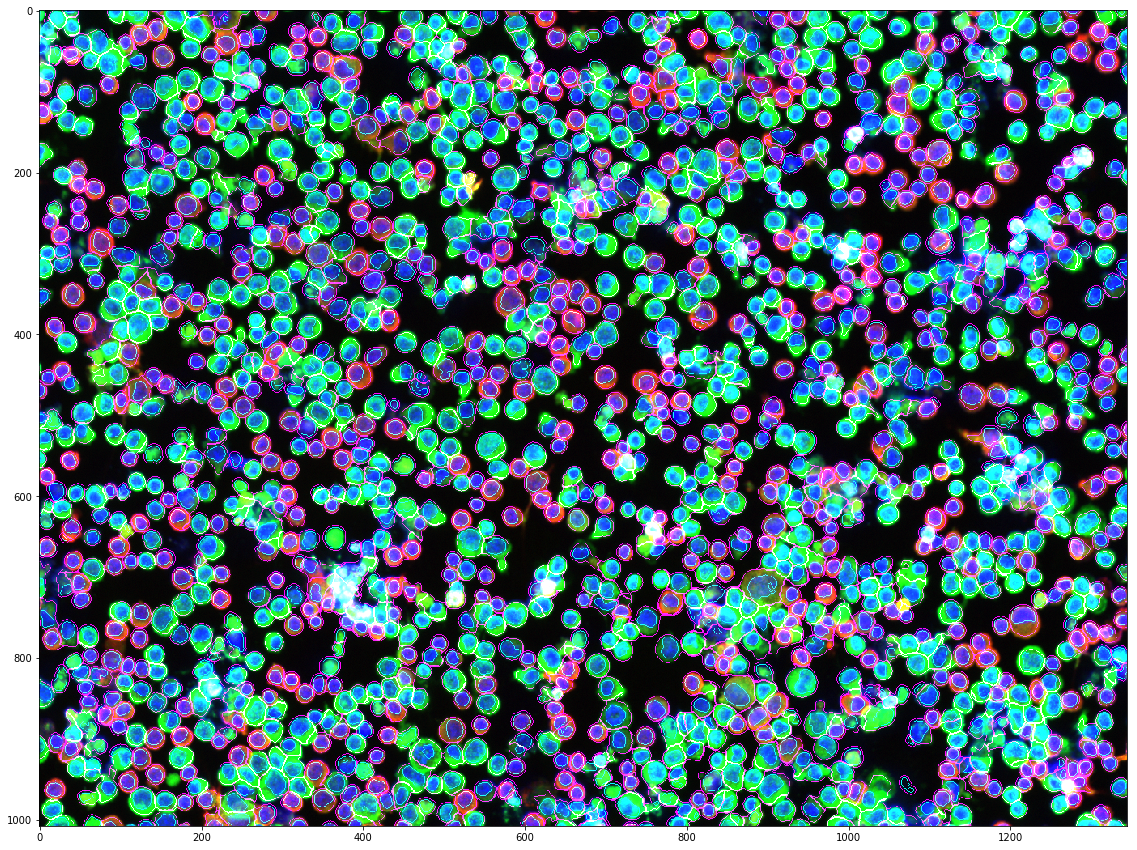

In [14]:
# Show the full size blended image
plt.imshow(img)
plt.gcf().set_size_inches(20, 15)

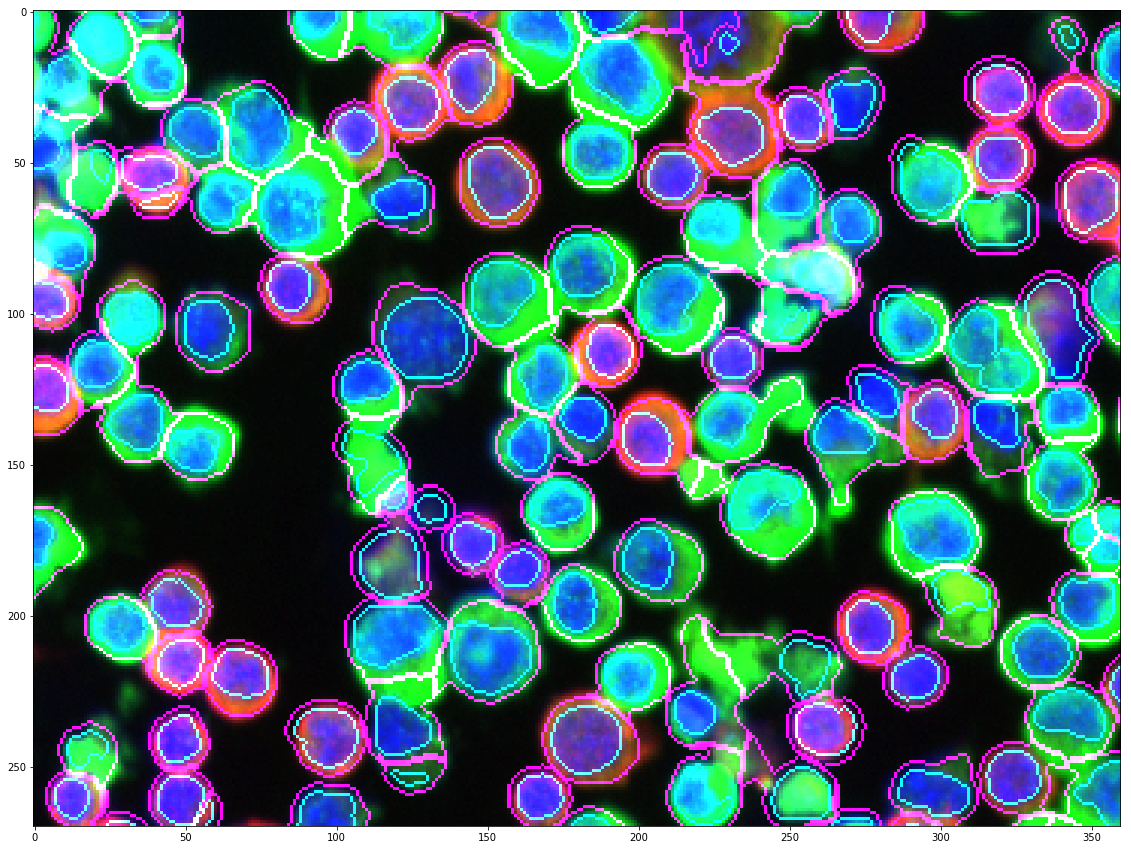

In [15]:
# Show a zoom on the upper left corner of the image
plt.imshow(img[:270, :360])
plt.gcf().set_size_inches(20, 15)

### Cytometry Data

A data frame containing all single cell data as well as corresponding images can be fetched as follows:

In [16]:
# Load numeric data only
df = ck_data.get_cytometry_data(variant_dir, config, mode='best_z_plane')

# Attach single cell images using the color/contrast settings from above
df = ck_data.get_single_cell_image_data(variant_dir, df, extract_name, ranges=ranges, colors=colors, image_size=(32, 32))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586 entries, 0 to 1585
Data columns (total 35 columns):
region_index           1586 non-null int64
tile_index             1586 non-null int64
tile_x                 1586 non-null int64
tile_y                 1586 non-null int64
rid                    1586 non-null int64
rx                     1586 non-null float64
ry                     1586 non-null float64
id                     1586 non-null int64
x                      1586 non-null float64
y                      1586 non-null float64
z                      1586 non-null int64
cell_size              1586 non-null float64
cell_diameter          1586 non-null float64
cell_perimeter         1586 non-null float64
cell_circularity       1586 non-null float64
cell_solidity          1586 non-null float64
nucleus_size           1586 non-null float64
nucleus_diameter       1586 non-null float64
nucleus_perimeter      1586 non-null float64
nucleus_circularity    1586 non-null float64
nucleus

Next, visualize a few of the distributions of morphological or graphical cell features:

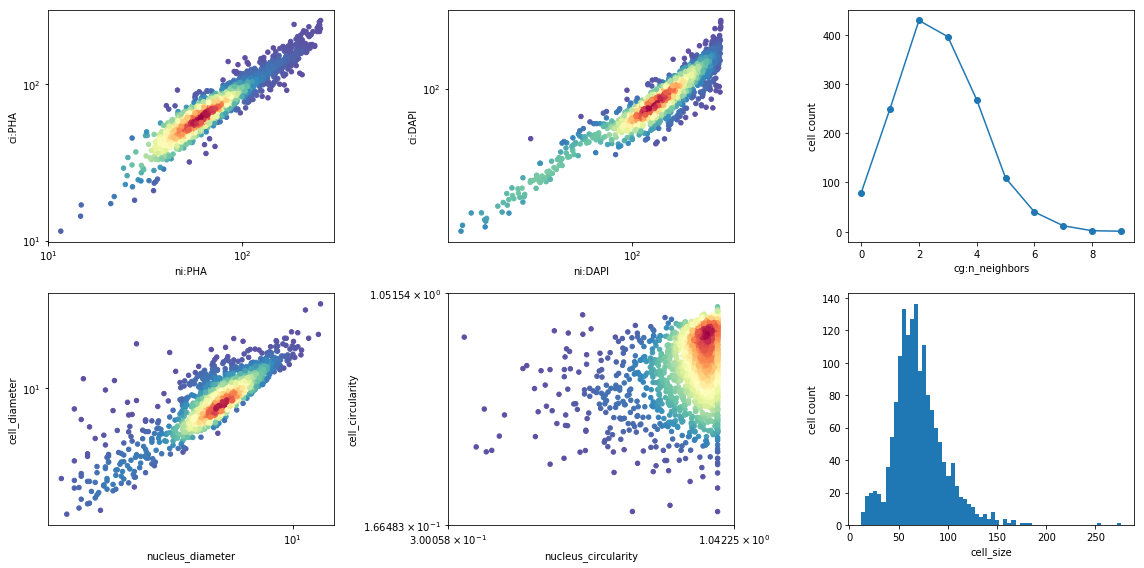

In [18]:
from scipy.stats import gaussian_kde

def plot_scatter(df, x, y, ax=None):
    X = df[[x, y]].values
    if ax is None:
        ax = plt.figure().gca()
    c = gaussian_kde(X.T)(X.T)
    df.plot(kind='scatter', x=x, y=y, c=c, ax=ax, cmap='Spectral_r', colorbar=False)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

fig, ax = plt.subplots(2, 3)
fig.set_size_inches(16, 8)
ax = ax.ravel()

plot_scatter(df, 'ni:PHA', 'ci:PHA', ax=ax[0])
plot_scatter(df, 'ni:DAPI', 'ci:DAPI', ax=ax[1])
plot_scatter(df, 'nucleus_diameter', 'cell_diameter', ax=ax[3])
plot_scatter(df, 'nucleus_circularity', 'cell_circularity', ax=ax[4])
df['cg:n_neighbors'].value_counts().sort_index().plot(kind='line', style='-o', ax=ax[2])
ax[2].set_xlabel('cg:n_neighbors')
ax[2].set_ylabel('cell count')
df['cell_size'].plot(kind='hist', bins=64, ax=ax[5])
ax[5].set_xlabel('cell_size')
ax[5].set_ylabel('cell count')
fig.tight_layout()

Lastly, show the CD4/CD8 bivariate distributions as well as paired single cell image plots to help verify that the two larger cell populations match expectations:

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_cells(df, n=10, random_state=None, ax=None):    
    df = df.sample(n=n, random_state=random_state)
    if ax is None:
        ax = plt.figure().gca()
    ax.scatter(df['ci:CD4'], df['ci:CD8']) 
    artists = []
    for i, r in df.iterrows():
        oi = OffsetImage(r['image'], zoom=1)
        ab = AnnotationBbox(oi, (r['ci:CD4'], r['ci:CD8']), frameon=False)
        artists.append(ax.add_artist(ab))
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

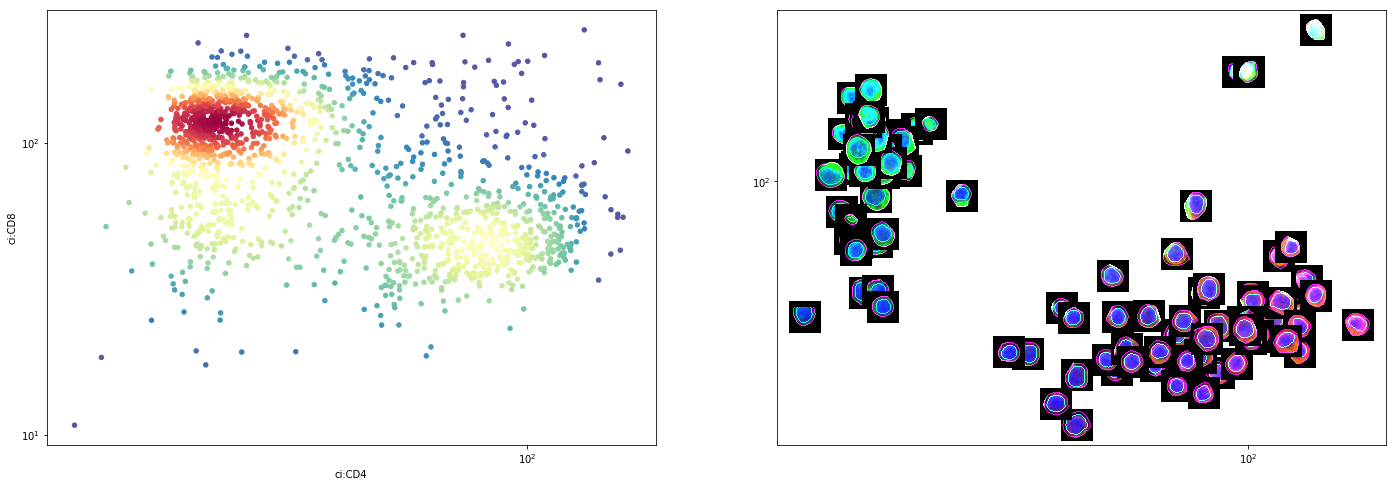

In [20]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 8)
plot_scatter(df, 'ci:CD4', 'ci:CD8', ax=ax[0])
plot_cells(df.query('cell_circularity > .9 & nucleus_circularity > .9'), n=100, random_state=1, ax=ax[1])

### Cytokit Explorer

Configuration for the Explorer GUI is defined through environment variables (at the moment).  These can be set before running the ```cytokit application run_explorer``` command which will run a server available by default at http://0.0.0.0:8050/.  

**Note**: If using docker, the port used below must also be made available when the container is run (e.g. ```nvidia-docker run -p 8050:8050```)

In [21]:
# This will run the GUI that can be stopped at any time in the notebook with a kernel interrupt
! \
export APP_EXP_NAME=$exp_name; \
export APP_EXP_DATA_DIR=$variant_dir; \
export APP_EXP_CONFIG_PATH=$variant_dir/config/experiment.yaml; \
export APP_EXTRACT_NAME=best_z_segm; \
export APP_MONTAGE_NAME=best_z_segm; \
export APP_MONTAGE_CHANNEL_NAMES="proc_CD4,proc_CD8"; \
export APP_MONTAGE_CHANNEL_COLORS="red,green"; \
export APP_MONTAGE_CHANNEL_RANGES="0-200,0-200"; \
export APP_PORT=8050; \
cytokit application run_explorer

2019-01-07 14:02:53,659:INFO:5333:root: Running explorer app
2019-01-07 14:02:54,442:INFO:5333:cytokit_app.explorer.data: Loading montage image for the first time (this may take a bit but is only necessary once)
2019-01-07 14:02:54,463:INFO:5333:cytokit_app.explorer.data: Loaded montage image with shape = (2, 1008, 1344), dtype = uint16
2019-01-07 14:02:54,496:INFO:5333:cytokit_app.explorer.data: Loading cytometry data from path "/tmp/cytokit-example/cellular-marker/20181116-d40-r1-20x-5by5/output/v00/cytometry/data.csv"
2019-01-07 14:02:54,734:INFO:5333:cytokit_app.explorer.data: Loaded tile image for tile x = 0, tile y = 0, shape = (6, 1008, 1344), dtype = uint16
 * Serving Flask app "cytokit" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
2019-01-07 14:02:55,834:INFO:5333:werkzeug:  * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
2019-01-07 14:02:55,834:INFO:5333:werkzeug:  * Restarting with stat
2019-01-07 14:03:04,552: